In [1]:
from typing import List, Tuple

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange

from scipy.stats.distributions import beta
from scipy.stats import skew

sns.set()

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
k = 0.05

In [4]:
def reward(i: int) -> float:
    return i

def distance(i: int) -> int:
    return i**2

In [5]:
def run_pathworld(i: int, lam: float) -> float:
    """
    Runs a single pathworld experiment, outputting the reward trajectory (or value later)
    
    Args:
        i: chosen path, with $i$ reward and $i^2$ distance
        lam: risk, induces per-step-risk of dying of (1 - exp(-lam))
    """

    risk = np.exp(-lam*distance(i))
    
    if np.random.rand() < risk:
        # success
        return reward(i)
    else:
        return 0


In [6]:
def multi_pathworld(i: int, lam: float, n: int) -> float:
    vals = []
    for _ in range(n):
        vals.append(run_pathworld(i, lam))
    return np.mean(vals)

In [7]:
def exp_discount(i: int, gamma: float) -> float:
    return gamma**(distance(i)) * reward(i)

In [8]:
def hyperbolic_discount(i: int, k: float) -> float:  # exactly equal to theoretical
    return reward(i) / (1 + k * distance(i))

In [9]:
def beta_discount(i: int, alpha: float, beta: float) -> float:
    res = 1
    for j in range(0, distance(i)):
        res *= (alpha + j) / (alpha + beta + j)
    return res * reward(i)

In [10]:
def mse(xs: List[float], ys: List[float]) -> float:
    xs = np.array(xs)
    ys = np.array(ys)
    return np.mean((xs - ys)**2)

In [13]:
def heuristic_beta_params(g_min: float, g_max: float) -> Tuple[float, float]:
    g_m = (g_min + g_max)/2.
    p = (1-g_m)/g_m
    sigma = 1-g_m
    
    a = (p - sigma**2)/sigma**2
    b = p*a
    
    return 2*a, 2*b

In [14]:
def heuristic_lambda(lam: float):
    return heuristic_beta_params(1.-2*lam, 1.)

# Figure 6

In [16]:
k = 0.05

In [23]:
means = []
gammas = {g: [] for g in [0.75, 0.9, 0.95, 0.975, 0.99]}
hypers = []
betas = []
theories = []

for i in trange(0, 15):
    vals = []
    for _ in range(10000):
        lam = np.random.exponential(k)
        vals.append(run_pathworld(i, lam))
    means.append(np.mean(vals))
    
    hypers.append(hyperbolic_discount(i, k))
    
    betas.append(beta_discount(i, 20, 1))
        
    for g in gammas:
        gammas[g].append(exp_discount(i, g))

100%|██████████| 15/15 [00:00<00:00, 24.12it/s]


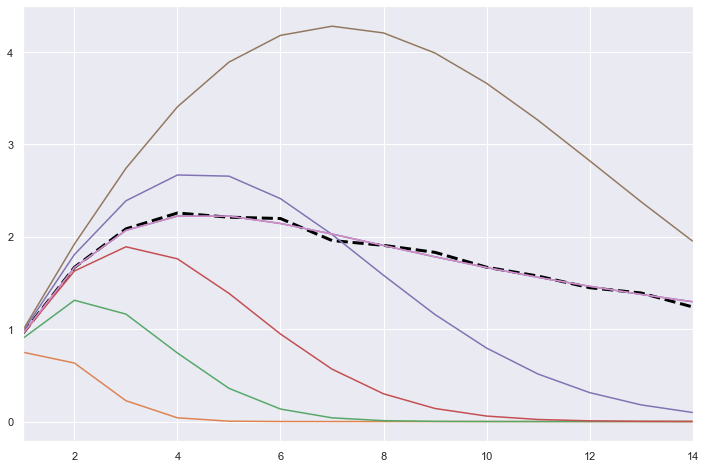

In [24]:
plt.plot(means, '--', c='black', lw=3)
plt.plot(hypers)
for g in gammas:
    plt.plot(gammas[g])
    
plt.plot(betas)
    
plt.xlim(1, 14)
plt.show()

# Figure 7

In [154]:
means = []
hypers = {h: [] for h in [0.025, 0.05, 0.1, 0.2]}
betas = []
theories = []

for i in trange(0, 15):
    vals = []
    for _ in range(10000):
        lam = np.random.exponential(k)
        vals.append(run_pathworld(i, lam))
        
    means.append(np.mean(vals))  # empirical
        
#     betas.append(beta_discount(i, 20, 1))
    
    for h in hypers:
        hypers[h].append(hyperbolic_discount(i, h))

100%|██████████| 15/15 [00:00<00:00, 24.07it/s]


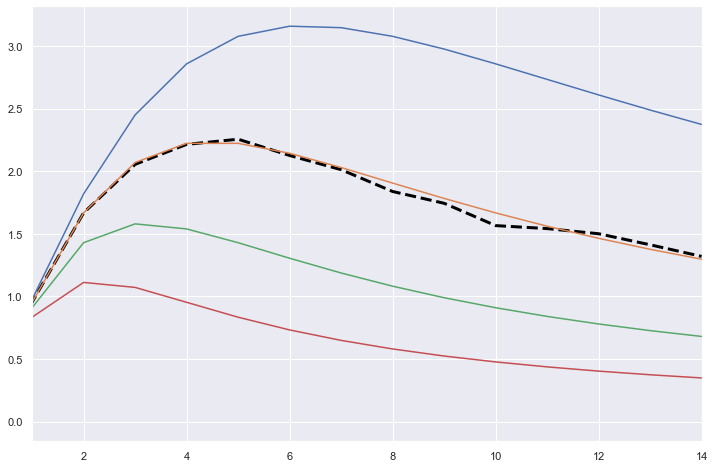

In [155]:
x = range(1, 15)

plt.plot(means, '--', c='black', lw=3)
for h in hypers:
    plt.plot(hypers[h])
    
# plt.plot(betas)
    
plt.xlim(1, 14)
plt.show()

# Figure 8

In [651]:
k = 0.05

In [652]:
means = []
gammas = {g: [] for g in [0.75, 0.9, 0.95, 0.975, 0.99]}
hypers = []
betas = []

for i in trange(0, 15):
    vals = []
    for _ in range(100000):
        delta = 0
        lam = np.random.uniform(0+delta, 2*k-delta)
        vals.append(run_pathworld(i, lam))
    means.append(np.mean(vals))
    
    hypers.append(hyperbolic_discount(i, k))
    
    a, b = heuristic_lambda(k)
    a, b = 2*a, 2*b
    
    betas.append(beta_discount(i, a, b))
        
    for g in gammas:
        gammas[g].append(exp_discount(i, g))

100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


In [653]:
print(f"Beta MSE:        {mse(means, betas):.3f}")
print(f"Hyperbolic MSE:  {mse(means, hypers):.3f}")

for g in [0.975, 0.95, 0.99]:
    print(f"MSE for γ={g:.3f}: {mse(means, gammas[g]):.3f}")
    


Beta MSE:        0.045
Hyperbolic MSE:  0.242
MSE for γ=0.975: 0.243
MSE for γ=0.950: 0.457
MSE for γ=0.990: 3.932


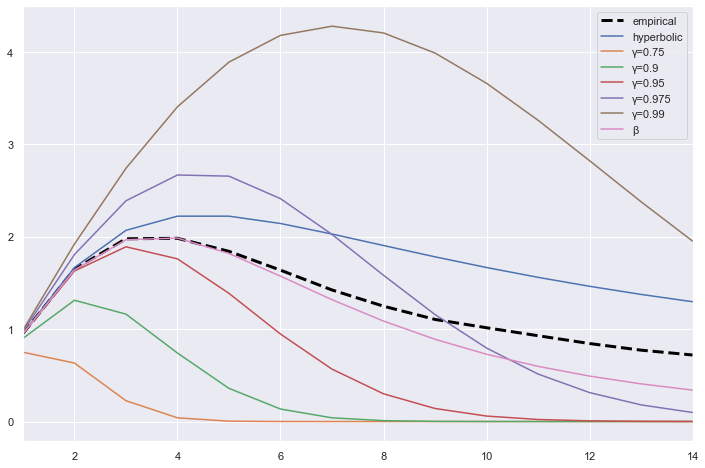

In [654]:
x = range(1, 15)

plt.plot(means, '--', c='black', lw=3, label="empirical")
plt.plot(hypers, label="hyperbolic")
for g in gammas:
    plt.plot(gammas[g], label=f"γ={g}")
    
plt.plot(betas, label="β")
    
plt.xlim(1, 14)
plt.legend()
plt.show()

In [26]:
np.argmax(means)

4

In [27]:
np.argmax(hypers)

4

In [28]:
np.argmax(betas)

4

In [29]:
for g in gammas:
    print(np.argmax(gammas[g]))

1
2
3
4
7


# Unknown constant risk

In [583]:
all_means = []
all_hypers = []
all_betas = []
all_gammas = []

k = 0.01
x = np.linspace(k-k, 2*k, 1000)

for lam in tqdm(x):
    means = []
    hypers = []
    betas = []
    gammas = []
    for i in range(0, 5):
        # Ground truth
#         means.append(multi_pathworld(i, lam, 1000))
        means.append(exp_discount(i, 1-lam))
        
        # Hyperbolic discounting
        hypers.append(hyperbolic_discount(i, k))
        
        # Beta discounting
        a, b = heuristic_lambda(k)
        betas.append(beta_discount(i, a, 1.1))
        
        gammas.append(exp_discount(i, 1-k))
        
    all_means.append(means)
    all_hypers.append(hypers)
    all_betas.append(betas)
    all_gammas.append(gammas)
    
all_means = np.array(all_means)
all_hypers = np.array(all_hypers)
all_betas = np.array(all_betas)
all_gammas = np.array(all_gammas)

hyper_errors = np.mean((all_means - all_hypers)**2, axis=1)

gamma_errors = np.mean((all_means - all_gammas)**2, axis=1)

beta_errors = np.mean((all_means - all_betas)**2, axis=1)

100%|██████████| 1000/1000 [00:00<00:00, 40338.77it/s]


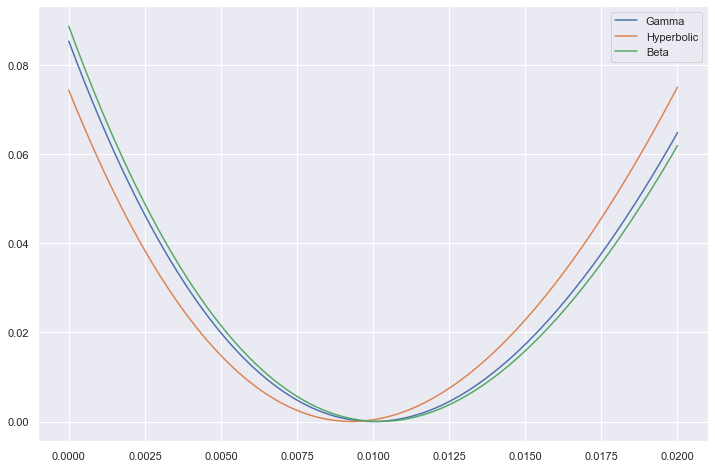

In [584]:

plt.plot(x, gamma_errors, label="Gamma")
plt.plot(x, hyper_errors, label="Hyperbolic")
plt.plot(x, beta_errors, label="Beta")

plt.legend()
plt.show()

In [572]:
print(f"Gamma error: {gamma_errors.mean():.3f}")
print(f"Hyper error: {hyper_errors.mean():.3f}")
print(f"Beta error:  {beta_errors.mean():.3f}")

Gamma error: 1.000
Hyper error: 0.975
Beta error:  0.942


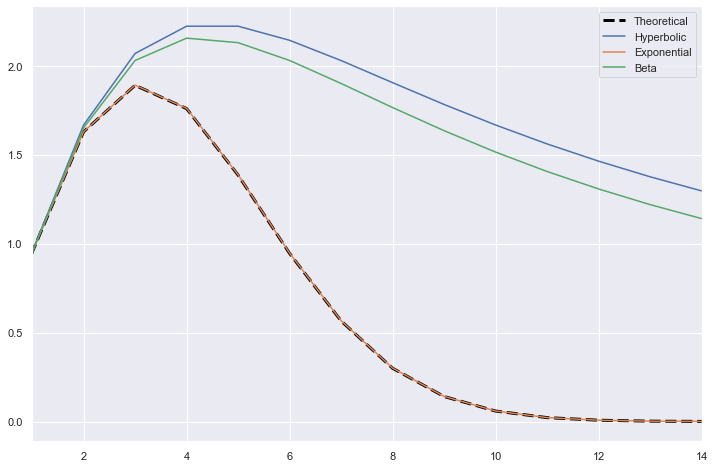

In [515]:

idx = 500

plt.plot(all_means[idx], '--', c='black', lw=3, label="Theoretical")
plt.plot(all_hypers[idx], label="Hyperbolic")
plt.plot(all_gammas[idx], label="Exponential")
plt.plot(all_betas[idx], label="Beta")
    
plt.xlim(1, 14)
plt.legend()
plt.show()

# Constant risk

In [413]:
means = []
gammas = {g: [] for g in [0.75, 0.9, 0.95, 0.975, 0.99]}
hypers = []
betas = []

for i in trange(0, 15):
    vals = []
    means.append(multi_pathworld(i, 0.05, 10000))
    
    hypers.append(hyperbolic_discount(i, k))
    
    betas.append(beta_discount(i, 20, 1))
        
    for g in gammas:
        gammas[g].append(exp_discount(i, g))

100%|██████████| 15/15 [00:00<00:00, 58.74it/s]


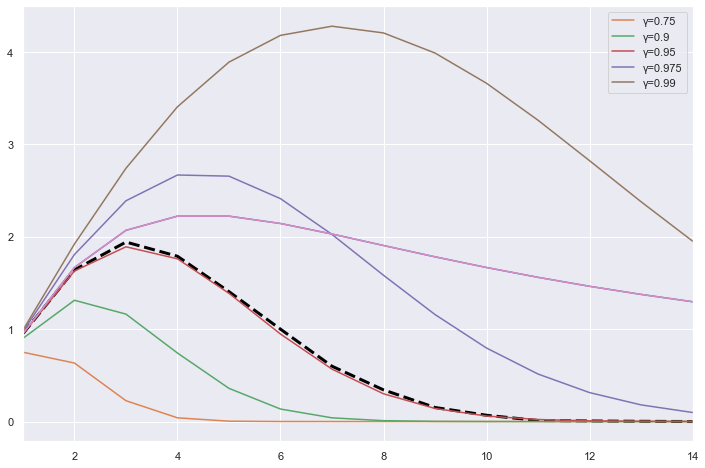

In [414]:

plt.plot(means, '--', c='black', lw=3)
plt.plot(hypers)
for g in gammas:
    plt.plot(gammas[g], label=f"γ={g}")
    
plt.plot(betas)
    
plt.xlim(1, 14)
plt.legend()
plt.show()

# Normal risk distribution

In [202]:
means = []
gammas = {g: [] for g in [0.75, 0.9, 0.95, 0.975, 0.99]}
hypers = []
betas = []
theories = []

for i in trange(0, 15):
    vals = []
    for _ in range(10000):
        lam = np.random.normal(k, k/3)
        vals.append(run_pathworld(i, lam))
    means.append(np.mean(vals))
    
    hypers.append(hyperbolic_discount(i, k))
    
    betas.append(beta_discount(i, 30, 1.5))
        
    for g in gammas:
        gammas[g].append(exp_discount(i, g))

100%|██████████| 15/15 [00:00<00:00, 23.13it/s]


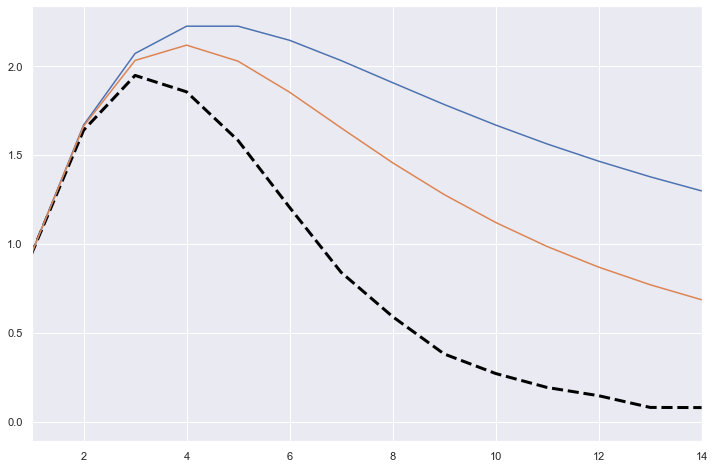

In [203]:
x = range(1, 15)

plt.plot(means, '--', c='black', lw=3)
plt.plot(hypers)
# for g in gammas:
#     plt.plot(gammas[g])
    
plt.plot(betas)
    
plt.xlim(1, 14)
plt.show()

In [268]:
((1/19) - 0.05**2) / 0.05**2

20.052631578947363

# IDEA

Devise an alternative pathworld, with rewards at different scales instead. Perhaps a general way?

In [4]:
def plot_beta(a: float, b: float):
    dist = beta(a, b)
    X = np.linspace(0, 1, 1001)
    Y = dist.pdf(X)
    plt.plot(X, Y)
    plt.show()
    return X, Y

In [649]:
a, b = heuristic_lambda(0.05)

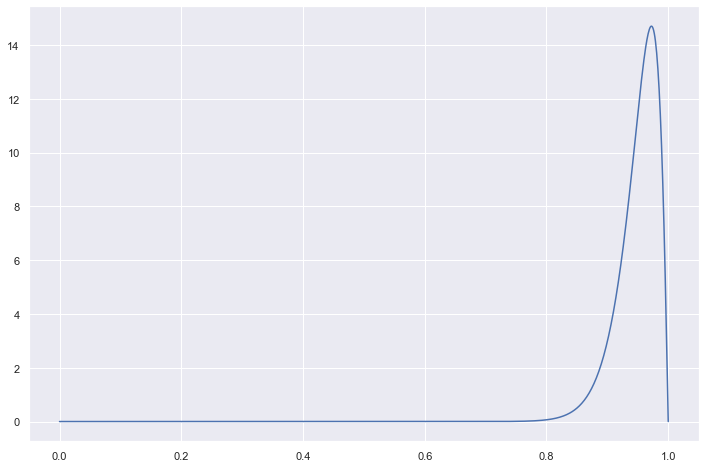

In [655]:
data = plot_beta(a, b)

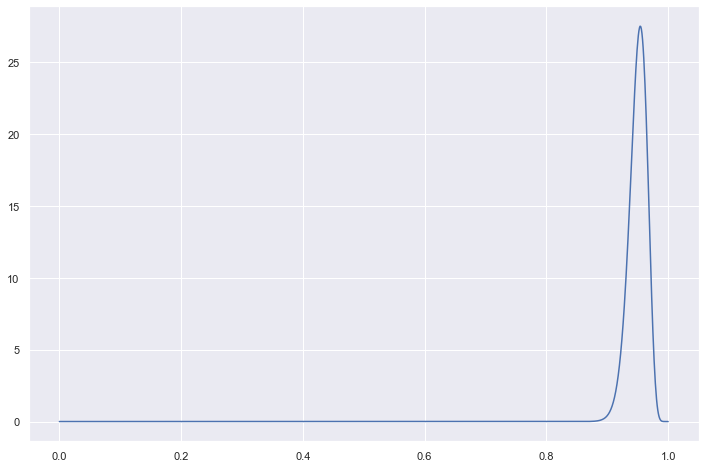

In [657]:
data = plot_beta(5*a, 5*b)

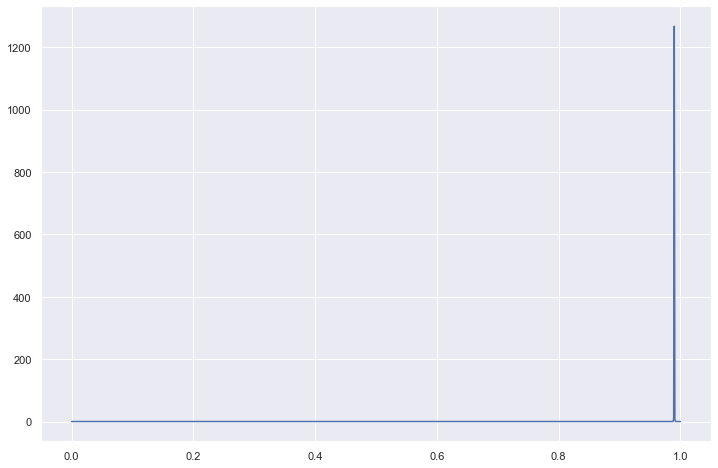

In [9]:
factor = 1000
data = plot_beta(99*factor, 1*factor)

In [658]:
beta(5*a, 5*b).std()

0.014965685248475602

In [587]:
(1/2)**(1/20)

0.9659363289248456